# 第11章: Regression with a Binary Dependent Variable（二値従属変数の回帰）練習問題

この章では線形確率モデル、プロビット、ロジットについて学びます。

In [1]:
library(AER)
data("HMDA")  # 住宅ローンデータ

Loading required package: car



Loading required package: carData



Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: sandwich



Loading required package: survival



---
## 問題1: データの確認と線形確率モデル

HMDAデータを使って住宅ローンの承認/拒否を分析します。

1. deny変数（ローン拒否）の分布を確認
2. deny ~ pirat（負債所得比率）の線形確率モデルを推定
3. 結果を解釈

In [2]:
# 問題1の解答欄



### 模範解答

In [3]:
# 模範解答
# deny変数を数値に変換（yes=1, no=0）
HMDA$deny_num <- ifelse(HMDA$deny == "yes", 1, 0)

# 1. 分布の確認
cat("=== deny変数の分布 ===", "\n")
print(table(HMDA$deny))
cat("拒否率:", mean(HMDA$deny_num), "\n\n")

# 2. 線形確率モデル
lpm <- lm(deny_num ~ pirat, data = HMDA)
cat("=== 線形確率モデル ===", "\n")
summary(lpm)

# 3. 解釈
cat("\n=== 解釈 ===", "\n")
cat("piratの係数:", coef(lpm)[2], "\n")
cat("→ 負債所得比率が0.1（10%ポイント）増加すると、\n")
cat("   拒否確率が約", round(coef(lpm)[2] * 0.1 * 100, 2), "%ポイント増加\n")

=== deny変数の分布 === 



  no  yes 
2095  285 


拒否率: 0.1197479 



=== 線形確率モデル === 



Call:
lm(formula = deny_num ~ pirat, data = HMDA)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.73070 -0.13736 -0.11322 -0.07097  1.05577 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07991    0.02116  -3.777 0.000163 ***
pirat        0.60353    0.06084   9.920  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3183 on 2378 degrees of freedom
Multiple R-squared:  0.03974,	Adjusted R-squared:  0.03933 
F-statistic: 98.41 on 1 and 2378 DF,  p-value: < 2.2e-16



=== 解釈 === 


piratの係数: 0.6035349 


→ 負債所得比率が0.1（10%ポイント）増加すると、


   拒否確率が約 6.04 %ポイント増加


---
## 問題2: 線形確率モデルの問題点

LPMの問題点を確認します。

1. 予測確率が[0,1]の範囲外になるケースを確認
2. 残差の分散不均一性を確認
3. ロバスト標準誤差を使った推定

In [4]:
# 問題2の解答欄



### 模範解答

=== 予測確率の範囲 === 


最小: -0.07990965 


最大: 1.730695 


範囲外の予測数: 40 



Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <8c>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <ac>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '残差の二乗 vs 予測値' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <ac>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '予測値' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(...):
“conversion failure on '残差²' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '残差²' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on '残差²' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on '残差²' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '残差²' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on '残差²' in 'mbcsToSbcs': dot substituted for <ae>”


=== 分散不均一性の理論 === 


LPMでは Var(u|X) = P(Y=1|X)(1-P(Y=1|X)) となり、


Xに依存するため分散不均一性が生じる



=== ロバスト標準誤差 === 



t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -0.079910   0.031967 -2.4998   0.01249 *  
pirat        0.603535   0.098483  6.1283 1.036e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


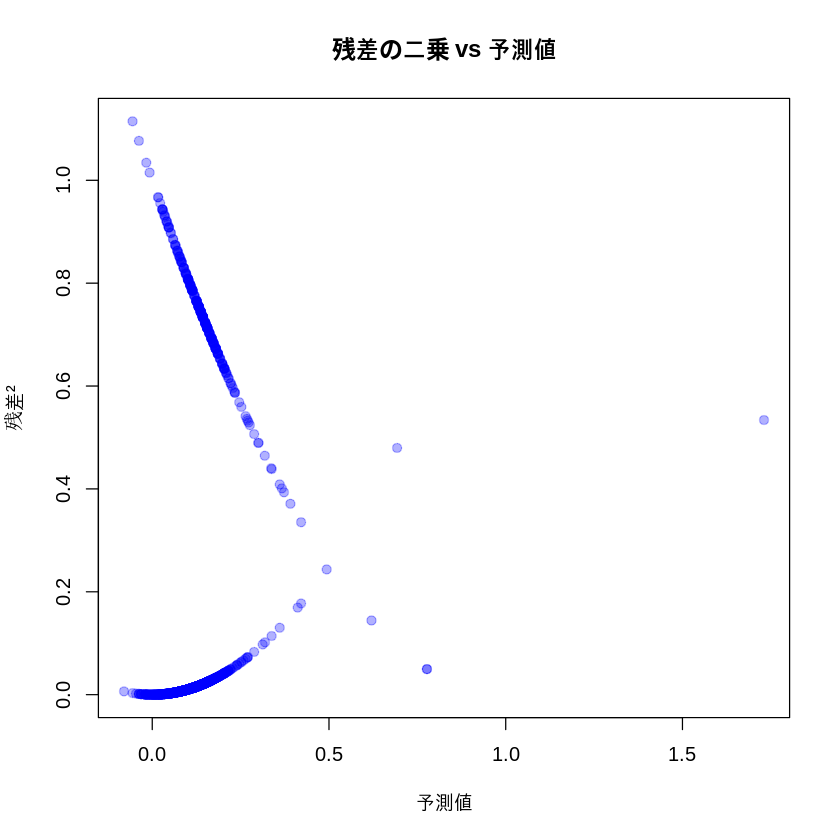

In [5]:
# 模範解答
library(lmtest)
library(sandwich)

# 1. 予測確率の範囲確認
pred_prob <- predict(lpm)
cat("=== 予測確率の範囲 ===", "\n")
cat("最小:", min(pred_prob), "\n")
cat("最大:", max(pred_prob), "\n")
cat("範囲外の予測数:", sum(pred_prob < 0) + sum(pred_prob > 1), "\n\n")

# 2. 残差の分散不均一性
plot(fitted(lpm), resid(lpm)^2,
     main = "残差の二乗 vs 予測値",
     xlab = "予測値", ylab = "残差²",
     pch = 19, col = rgb(0, 0, 1, 0.3))

# LPMでは分散が P(1-P) となり不均一
cat("=== 分散不均一性の理論 ===", "\n")
cat("LPMでは Var(u|X) = P(Y=1|X)(1-P(Y=1|X)) となり、\n")
cat("Xに依存するため分散不均一性が生じる\n\n")

# 3. ロバスト標準誤差
cat("=== ロバスト標準誤差 ===", "\n")
coeftest(lpm, vcov = vcovHC(lpm, type = "HC1"))

---
## 問題3: プロビットモデル

プロビットモデルを推定します。

1. glm()関数でプロビットモデルを推定
2. 係数を解釈
3. LPMとの比較

In [6]:
# 問題3の解答欄



### 模範解答

=== プロビットモデル === 



Call:
glm(formula = deny_num ~ pirat, family = binomial(link = "probit"), 
    data = HMDA)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4140  -0.5281  -0.4750  -0.3900   2.8159  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.1941     0.1378 -15.927  < 2e-16 ***
pirat         2.9679     0.3858   7.694 1.43e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1744.2  on 2379  degrees of freedom
Residual deviance: 1663.6  on 2378  degrees of freedom
AIC: 1667.6

Number of Fisher Scoring iterations: 6



=== 係数の解釈 === 


プロビット係数はz値（標準正規分布の引数）への効果を示す


直接的な確率への効果は限界効果として計算する必要がある



Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'LPM vs プロビット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <b2>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <b5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <94>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <92>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <88>”


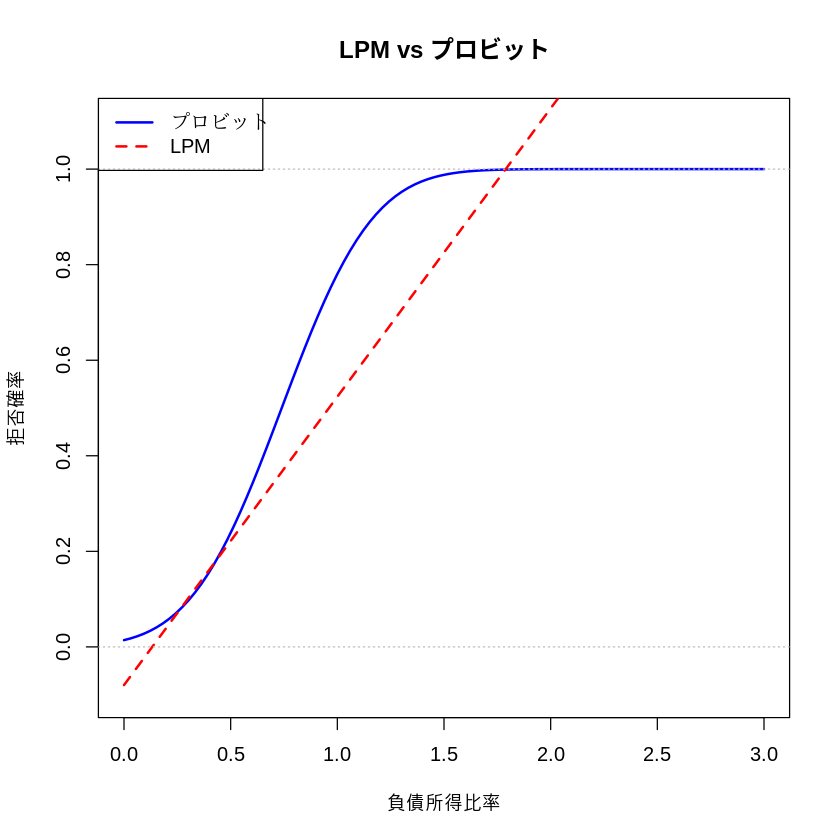

In [7]:
# 模範解答
# 1. プロビットモデル
probit <- glm(deny_num ~ pirat, data = HMDA, family = binomial(link = "probit"))
cat("=== プロビットモデル ===", "\n")
summary(probit)

# 2. 係数の解釈
cat("\n=== 係数の解釈 ===", "\n")
cat("プロビット係数はz値（標準正規分布の引数）への効果を示す\n")
cat("直接的な確率への効果は限界効果として計算する必要がある\n\n")

# 3. LPMとの比較（予測確率）
pirat_range <- seq(0, 3, length.out = 100)
pred_lpm <- predict(lpm, newdata = data.frame(pirat = pirat_range))
pred_probit <- predict(probit, newdata = data.frame(pirat = pirat_range), type = "response")

plot(pirat_range, pred_probit, type = "l", col = "blue", lwd = 2,
     main = "LPM vs プロビット",
     xlab = "負債所得比率", ylab = "拒否確率",
     ylim = c(-0.1, 1.1))
lines(pirat_range, pred_lpm, col = "red", lwd = 2, lty = 2)
abline(h = c(0, 1), col = "gray", lty = 3)
legend("topleft", legend = c("プロビット", "LPM"), 
       col = c("blue", "red"), lty = c(1, 2), lwd = 2)

---
## 問題4: ロジットモデル

ロジットモデルを推定し、オッズ比を計算します。

1. ロジットモデルを推定
2. オッズ比を計算
3. プロビットモデルとの比較

In [8]:
# 問題4の解答欄



### 模範解答

=== ロジットモデル === 



Call:
glm(formula = deny_num ~ pirat, family = binomial(link = "logit"), 
    data = HMDA)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6583  -0.5255  -0.4705  -0.3864   2.7624  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.0284     0.2686 -14.999  < 2e-16 ***
pirat         5.8845     0.7336   8.021 1.05e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1744.2  on 2379  degrees of freedom
Residual deviance: 1660.2  on 2378  degrees of freedom
AIC: 1664.2

Number of Fisher Scoring iterations: 5



=== オッズ比 === 


 (Intercept)        pirat 
  0.01780222 359.42220584 



piratが0.1増加するとオッズは 1.801194 倍になる


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on 'プロビット vs ロジット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <b2>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <b5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <94>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <92>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'プロビット' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <ad>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'ロジット' in 'mbcsToSbcs': dot substituted for <88>”



→ プロビットとロジットの予測確率はほぼ同じ


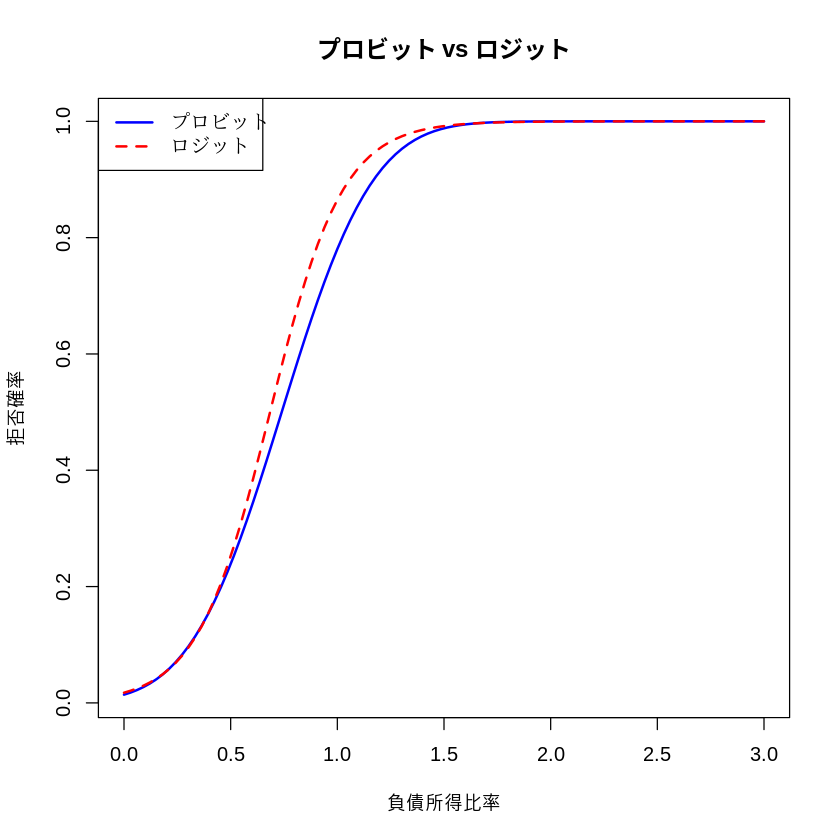

In [9]:
# 模範解答
# 1. ロジットモデル
logit <- glm(deny_num ~ pirat, data = HMDA, family = binomial(link = "logit"))
cat("=== ロジットモデル ===", "\n")
summary(logit)

# 2. オッズ比
cat("\n=== オッズ比 ===", "\n")
odds_ratio <- exp(coef(logit))
print(odds_ratio)
cat("\npiratが0.1増加するとオッズは", exp(coef(logit)[2] * 0.1), "倍になる\n")

# 3. プロビットとロジットの比較
pred_logit <- predict(logit, newdata = data.frame(pirat = pirat_range), type = "response")

plot(pirat_range, pred_probit, type = "l", col = "blue", lwd = 2,
     main = "プロビット vs ロジット",
     xlab = "負債所得比率", ylab = "拒否確率")
lines(pirat_range, pred_logit, col = "red", lwd = 2, lty = 2)
legend("topleft", legend = c("プロビット", "ロジット"), 
       col = c("blue", "red"), lty = c(1, 2), lwd = 2)

cat("\n→ プロビットとロジットの予測確率はほぼ同じ\n")

---
## 問題5: 限界効果の計算

プロビットモデルの限界効果を計算します。

1. 平均での限界効果（MEM: Marginal Effect at Mean）を計算
2. 平均限界効果（AME: Average Marginal Effect）を計算
3. 両者を比較

In [10]:
# 問題5の解答欄



### 模範解答

In [11]:
# 模範解答
# プロビットモデル
probit <- glm(deny_num ~ pirat, data = HMDA, family = binomial(link = "probit"))

# 1. 平均での限界効果（MEM）
# ∂P(Y=1)/∂X = φ(X'β) * β
mean_pirat <- mean(HMDA$pirat)
linear_pred_mean <- coef(probit)[1] + coef(probit)[2] * mean_pirat
mem <- dnorm(linear_pred_mean) * coef(probit)[2]

cat("=== 平均での限界効果（MEM）===", "\n")
cat("piratの平均:", mean_pirat, "\n")
cat("MEM:", mem, "\n\n")

# 2. 平均限界効果（AME）
linear_pred_all <- predict(probit, type = "link")
marginal_effects <- dnorm(linear_pred_all) * coef(probit)[2]
ame <- mean(marginal_effects)

cat("=== 平均限界効果（AME）===", "\n")
cat("AME:", ame, "\n\n")

# 3. 比較
cat("=== 比較 ===", "\n")
cat("MEM:", mem, "\n")
cat("AME:", ame, "\n")
cat("LPM係数:", coef(lpm)[2], "\n")
cat("\n→ AMEとLPM係数は近い値になることが多い\n")

=== 平均での限界効果（MEM）=== 


piratの平均: 0.3308136 


MEM: 0.5678076 



=== 平均限界効果（AME）=== 


AME: 0.5664755 



=== 比較 === 


MEM: 0.5678076 


AME: 0.5664755 


LPM係数: 0.6035349 



→ AMEとLPM係数は近い値になることが多い


---
## 問題6: 複数の説明変数を含むモデル

複数の説明変数を含むプロビットモデルを推定します。

1. deny ~ pirat + afam のモデルを推定（afam: アフリカ系アメリカ人ダミー）
2. 各変数の限界効果を計算
3. 結果を解釈

In [12]:
# 問題6の解答欄



### 模範解答

In [13]:
# 模範解答
# afam変数の作成
HMDA$afam_num <- ifelse(HMDA$afam == "yes", 1, 0)

# 1. プロビットモデル
probit_multi <- glm(deny_num ~ pirat + afam_num, data = HMDA, 
                    family = binomial(link = "probit"))
cat("=== 複数説明変数のプロビットモデル ===", "\n")
summary(probit_multi)

# 2. 限界効果（AME）
linear_pred <- predict(probit_multi, type = "link")
phi <- dnorm(linear_pred)

ame_pirat <- mean(phi * coef(probit_multi)["pirat"])
ame_afam <- mean(phi * coef(probit_multi)["afam_num"])

cat("\n=== 平均限界効果（AME）===", "\n")
cat("piratのAME:", ame_pirat, "\n")
cat("afamのAME:", ame_afam, "\n\n")

# 3. 解釈
cat("=== 解釈 ===", "\n")
cat("piratが0.1増加すると、拒否確率は約", round(ame_pirat * 0.1 * 100, 2), "%ポイント増加\n")
cat("アフリカ系アメリカ人であることは、拒否確率を約", 
    round(ame_afam * 100, 2), "%ポイント増加させる\n")

=== 複数説明変数のプロビットモデル === 



Call:
glm(formula = deny_num ~ pirat + afam_num, family = binomial(link = "probit"), 
    data = HMDA)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1208  -0.4762  -0.4251  -0.3550   2.8799  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.25879    0.13669 -16.525  < 2e-16 ***
pirat        2.74178    0.38047   7.206 5.75e-13 ***
afam_num     0.70816    0.08335   8.496  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1744.2  on 2379  degrees of freedom
Residual deviance: 1594.3  on 2377  degrees of freedom
AIC: 1600.3

Number of Fisher Scoring iterations: 5



=== 平均限界効果（AME）=== 


piratのAME: 0.5014202 


afamのAME: 0.1295084 



=== 解釈 === 


piratが0.1増加すると、拒否確率は約 5.01 %ポイント増加


アフリカ系アメリカ人であることは、拒否確率を約 12.95 %ポイント増加させる


---
## 問題7: モデルの適合度

二値選択モデルの適合度を評価します。

1. 疑似R²（McFadden's R²）を計算
2. 的中率を計算
3. ROC曲線を描画

In [14]:
# 問題7の解答欄



### 模範解答

=== McFadden's R² === 


R²: 0.08594259 



=== 的中率 === 


閾値0.5での的中率: 0.8819328 



混同行列:


         Actual
Predicted    0    1
        0 2089  275
        1    6   10


Warning message in title(...):
“conversion failure on 'ROC曲線' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on 'ROC曲線' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on 'ROC曲線' in 'mbcsToSbcs': dot substituted for <b2>”


Warning message in title(...):
“conversion failure on 'ROC曲線' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on 'ROC曲線' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on 'ROC曲線' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '偽陽性率 (FPR)' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <99>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '真陽性率 (TPR)' in 'mbcsToSbcs': dot substituted for <87>”



AUC: 0.7018582 


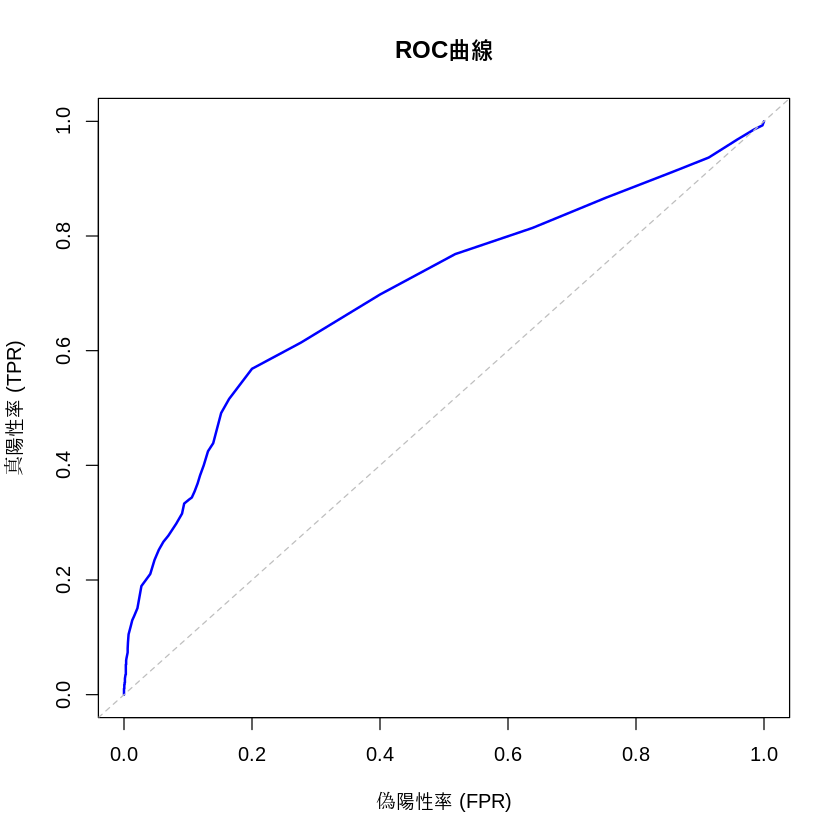

In [15]:
# 模範解答
probit_full <- glm(deny_num ~ pirat + afam_num, data = HMDA, 
                   family = binomial(link = "probit"))
probit_null <- glm(deny_num ~ 1, data = HMDA, family = binomial(link = "probit"))

# 1. McFadden's R²
mcfadden_r2 <- 1 - logLik(probit_full) / logLik(probit_null)
cat("=== McFadden's R² ===", "\n")
cat("R²:", as.numeric(mcfadden_r2), "\n\n")

# 2. 的中率
pred_prob <- predict(probit_full, type = "response")
pred_class <- ifelse(pred_prob > 0.5, 1, 0)
accuracy <- mean(pred_class == HMDA$deny_num)

cat("=== 的中率 ===", "\n")
cat("閾値0.5での的中率:", accuracy, "\n")

# 混同行列
cat("\n混同行列:\n")
print(table(Predicted = pred_class, Actual = HMDA$deny_num))

# 3. ROC曲線（簡易版）
thresholds <- seq(0, 1, by = 0.01)
tpr <- sapply(thresholds, function(t) mean(pred_prob[HMDA$deny_num == 1] > t))
fpr <- sapply(thresholds, function(t) mean(pred_prob[HMDA$deny_num == 0] > t))

plot(fpr, tpr, type = "l", col = "blue", lwd = 2,
     main = "ROC曲線",
     xlab = "偽陽性率 (FPR)", ylab = "真陽性率 (TPR)")
abline(0, 1, col = "gray", lty = 2)

# AUCの簡易計算
auc <- -sum(diff(fpr) * (tpr[-1] + tpr[-length(tpr)]) / 2)
cat("\nAUC:", auc, "\n")

---
## 問題8: 最尤推定の原理

プロビットモデルの最尤推定を理解します。

1. 対数尤度関数を手動で計算
2. optim()を使って最尤推定を実行
3. glm()の結果と比較

In [16]:
# 問題8の解答欄



### 模範解答

In [17]:
# 模範解答
# データの準備
y <- HMDA$deny_num
X <- cbind(1, HMDA$pirat)

# 1. 対数尤度関数
log_likelihood <- function(beta, y, X) {
  p <- pnorm(X %*% beta)
  # 数値的安定性のため、極端な値を制限
  p <- pmax(pmin(p, 1 - 1e-10), 1e-10)
  ll <- sum(y * log(p) + (1 - y) * log(1 - p))
  return(-ll)  # 最小化するため負の対数尤度
}

# 2. optim()による最尤推定
initial <- c(0, 0)
result <- optim(initial, log_likelihood, y = y, X = X, method = "BFGS")

cat("=== optim()による推定結果 ===", "\n")
cat("切片:", result$par[1], "\n")
cat("pirat:", result$par[2], "\n\n")

# 3. glm()との比較
probit_glm <- glm(deny_num ~ pirat, data = HMDA, family = binomial(link = "probit"))

cat("=== glm()による推定結果 ===", "\n")
cat("切片:", coef(probit_glm)[1], "\n")
cat("pirat:", coef(probit_glm)[2], "\n\n")

cat("→ 両者の結果はほぼ一致する\n")

=== optim()による推定結果 === 


切片: -2.19416 


pirat: 2.967911 



=== glm()による推定結果 === 


切片: -2.194145 


pirat: 2.967867 



→ 両者の結果はほぼ一致する


---
## 問題9: 尤度比検定

モデルの有意性を尤度比検定で確認します。

1. 帰無モデル（定数項のみ）と完全モデルを推定
2. 尤度比検定統計量を計算
3. p値を求めて結論を述べる

In [18]:
# 問題9の解答欄



### 模範解答

In [19]:
# 模範解答
# 1. モデルの推定
model_null <- glm(deny_num ~ 1, data = HMDA, family = binomial(link = "probit"))
model_full <- glm(deny_num ~ pirat + afam_num, data = HMDA, 
                  family = binomial(link = "probit"))

# 対数尤度
ll_null <- logLik(model_null)
ll_full <- logLik(model_full)

cat("=== 対数尤度 ===", "\n")
cat("帰無モデル:", as.numeric(ll_null), "\n")
cat("完全モデル:", as.numeric(ll_full), "\n\n")

# 2. 尤度比検定統計量
lr_stat <- 2 * (ll_full - ll_null)
df <- 2  # 追加されたパラメータの数

cat("=== 尤度比検定 ===", "\n")
cat("LR統計量:", as.numeric(lr_stat), "\n")
cat("自由度:", df, "\n")

# 3. p値
p_value <- 1 - pchisq(as.numeric(lr_stat), df)
cat("p値:", p_value, "\n\n")

# anova()関数での確認
cat("=== anova()による確認 ===", "\n")
print(anova(model_null, model_full, test = "LRT"))

=== 対数尤度 === 


帰無モデル: -872.0853 


完全モデル: -797.136 



=== 尤度比検定 === 


LR統計量: 149.8985 


自由度: 2 


p値: 0 



=== anova()による確認 === 


Analysis of Deviance Table

Model 1: deny_num ~ 1
Model 2: deny_num ~ pirat + afam_num
  Resid. Df Resid. Dev Df Deviance  Pr(>Chi)    
1      2379     1744.2                          
2      2377     1594.3  2    149.9 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


---
## 問題10: 交互作用項を含むモデル

交互作用効果を分析します。

1. deny ~ pirat * afam のプロビットモデルを推定
2. 人種によってpiratの効果が異なるか検定
3. グループ別の予測確率曲線を描画

In [20]:
# 問題10の解答欄



### 模範解答

=== 交互作用を含むプロビットモデル === 



Call:
glm(formula = deny_num ~ pirat * afam_num, family = binomial(link = "probit"), 
    data = HMDA)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0372  -0.4749  -0.4251  -0.3583   2.8509  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.2210     0.1496 -14.841  < 2e-16 ***
pirat            2.6318     0.4202   6.263 3.77e-10 ***
afam_num         0.4966     0.3528   1.408    0.159    
pirat:afam_num   0.5952     0.9627   0.618    0.536    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1744.2  on 2379  degrees of freedom
Residual deviance: 1593.9  on 2376  degrees of freedom
AIC: 1601.9

Number of Fisher Scoring iterations: 6



=== 交互作用項の尤度比検定 === 


Analysis of Deviance Table

Model 1: deny_num ~ pirat + afam_num
Model 2: deny_num ~ pirat * afam_num
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1      2377     1594.3                     
2      2376     1593.9  1   0.4121   0.5209


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <a5>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <92>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <9b>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <b2>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on '人種別の拒否確率曲線' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <b2>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <a0>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <b5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <be>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <97>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <94>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '負債所得比率' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <8b>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <92>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <90>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <a6>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <ba>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(...):
“conversion failure on '拒否確率' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <9d>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <bb>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <bb>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <9d>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <9e>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in text.default(x, y, ...):
“conversion failure on '非アフリカ系' in 'mbcsToSbcs': dot substituted for <bb>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <a2>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <aa>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <ab>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in text.default(x, y, ...):
“conversion failure on 'アフリカ系' in 'mbcsToSbcs': dot substituted for <bb>”



=== 解釈 === 


アフリカ系アメリカ人は、同じ負債所得比率でも


ローン拒否の確率が高い傾向が見られる


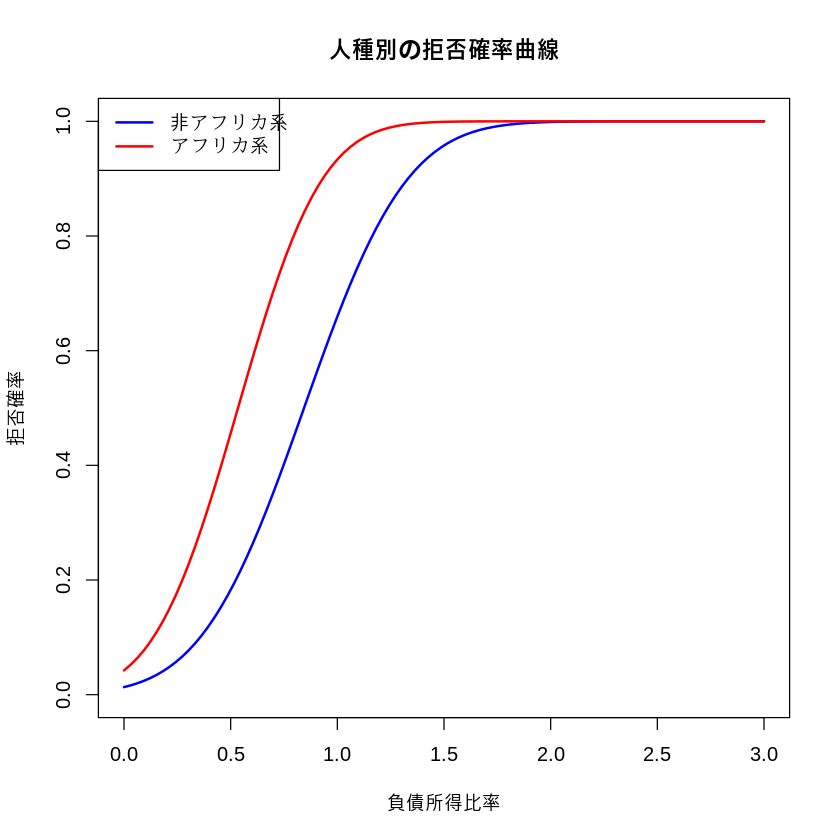

In [21]:
# 模範解答
# 1. 交互作用を含むモデル
probit_inter <- glm(deny_num ~ pirat * afam_num, data = HMDA, 
                    family = binomial(link = "probit"))
cat("=== 交互作用を含むプロビットモデル ===", "\n")
summary(probit_inter)

# 2. 交互作用項の検定
probit_main <- glm(deny_num ~ pirat + afam_num, data = HMDA, 
                   family = binomial(link = "probit"))
cat("\n=== 交互作用項の尤度比検定 ===", "\n")
print(anova(probit_main, probit_inter, test = "LRT"))

# 3. グループ別の予測確率曲線
pirat_range <- seq(0, 3, length.out = 100)

# 非アフリカ系（afam=0）
pred_non_afam <- predict(probit_inter, 
                         newdata = data.frame(pirat = pirat_range, afam_num = 0),
                         type = "response")
# アフリカ系（afam=1）
pred_afam <- predict(probit_inter, 
                     newdata = data.frame(pirat = pirat_range, afam_num = 1),
                     type = "response")

plot(pirat_range, pred_non_afam, type = "l", col = "blue", lwd = 2,
     main = "人種別の拒否確率曲線",
     xlab = "負債所得比率", ylab = "拒否確率",
     ylim = c(0, 1))
lines(pirat_range, pred_afam, col = "red", lwd = 2)
legend("topleft", legend = c("非アフリカ系", "アフリカ系"), 
       col = c("blue", "red"), lwd = 2)

cat("\n=== 解釈 ===", "\n")
cat("アフリカ系アメリカ人は、同じ負債所得比率でも\n")
cat("ローン拒否の確率が高い傾向が見られる\n")